In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
from hmmlearn import hmm
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
import functions_data_processing as fsd
from sklearn import svm
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import RocCurveDisplay
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc
from itertools import combinations
from sklearn.preprocessing import LabelBinarizer

In [79]:
# This cell changes the values of the df.csv file in order for the absent state to have a value of 0 instead of 0.1 and the present state to have a value of 1 instead of 0.9
# Furthermore it adds a new column in which we have both values of Microwave and Default combined

df_imported = pd.read_csv('df.csv', index_col=0)
df_imported = df_imported
df_imported.index = pd.to_datetime(df_imported.index)
df = pd.DataFrame()
df['Microwave'] = df_imported['Microwave']
df['Default'] = df_imported['Default']
df['Ground Truth'] = df_imported['Ground Truth']
df['Microwave - Default (combined)'] = 'temporary'
df['Garage door'] = df_imported['Garage door']

df =df.mask(df==0.9, 1)
df =df.mask(df==0.1, 0)

mask1 = (df['Microwave']==1.0) & (df['Default']==1.0)
mask2 = (df['Microwave']==0.0) & (df['Default']==1.0)
mask3 = (df['Microwave']==0.0) & (df['Default']==0.0)
mask4 = (df['Microwave']==1.0) & (df['Default']==0.0)

df['Microwave - Default (combined)'] = ''
df['Microwave - Default (combined)'] = df['Microwave - Default (combined)'].mask(mask1, '11')
df['Microwave - Default (combined)'] = df['Microwave - Default (combined)'].mask(mask2, '01')
df['Microwave - Default (combined)'] = df['Microwave - Default (combined)'].mask(mask3, '00')
df['Microwave - Default (combined)'] = df['Microwave - Default (combined)'].mask(mask4, '10')
df.iloc[:1025]

,Microwave,Default,Ground Truth,Microwave - Default (combined),Garage door
2016-01-01 05:00:00,0.0,1.0,1.0,01,0.0
2016-01-01 05:01:00,0.0,1.0,1.0,01,0.0
2016-01-01 05:02:00,0.0,1.0,1.0,01,0.0
2016-01-01 05:03:00,0.0,1.0,1.0,01,0.0
2016-01-01 05:04:00,0.0,1.0,1.0,01,0.0
...,...,...,...,...,...
2016-01-01 22:00:00,0.0,1.0,1.0,01,0.0
2016-01-01 22:01:00,0.0,1.0,1.0,01,0.0
2016-01-01 22:02:00,0.0,1.0,1.0,01,0.0
2016-01-01 22:03:00,0.0,1.0,1.0,01,0.0


In [80]:
# A function that selects a section of the data frame based on a starting date and interval

def interval_model(data_frame, starting_date, interval):
    
    s_date = pd.to_datetime(starting_date, format='%Y-%m-%d %H:%M:%S.%f')
    data_frame = data_frame.loc[s_date : s_date + interval]
    return data_frame

In [81]:
# An example of using the function interval_model defined above
df_model = df['Microwave - Default (combined)']

df_model = interval_model(data_frame= df_model, starting_date='2016-02-01 05:00:00', interval=datetime.timedelta(days=7))

df_model.iloc[:]

2016-02-01 05:00:00    01
2016-02-01 05:01:00    01
2016-02-01 05:02:00    01
2016-02-01 05:03:00    01
2016-02-01 05:04:00    01
                       ..
2016-02-08 04:56:00    01
2016-02-08 04:57:00    01
2016-02-08 04:58:00    01
2016-02-08 04:59:00    01
2016-02-08 05:00:00    01
Name: Microwave - Default (combined), Length: 10081, dtype: object

In [82]:
# The following cells are used just for testing and getting a feel for how the HMM model is deployed and can be ignored


y_true_original = interval_model(
    data_frame=df["Ground Truth"],
    starting_date="2016-02-01 05:00:00",
    interval=datetime.timedelta(days=7),
)


y_true_all_2 = []

y_pred_proba_all_2 = []
y_true_all = []


def sequence2counts(status, ostates2id):
    ans = []
    for word, idx in ostates2id.items():
        count = status.count(word)
        ans.append(count)
    return ans


# Smart home situation states: hidden state
h_states = ["absent", "present"]  # not at home, at home
id2hstates = dict(zip(range(len(h_states)), h_states))  # Dict from numbers to words

# Initial distribution of hidden states
start_probs = np.array([0.5, 0.5])

# microwave and GT: observable states:
# Pos 1: Default $Df$
# Pos 2: Microvave on off
o_states = ["00", "01", "10", "11"]
id2ostates = dict(zip(o_states, range(len(o_states))))

# Transition probs from hidden to observable states
emission_probs = np.array([[0.25, 0.1, 0.4, 0.25], [0.2, 0.5, 0.1, 0.2]])

# Transition matrix of hidden states
trans_mat = np.array([[0.95, 0.05], [0.05, 0.95]])

observations = df_model.values.tolist()


# Format observations
X = []
for status in observations:
    row = sequence2counts(status, id2ostates)
    X.append(row)
data = np.array(X, dtype=int)


n_trials = len(observations[0])


print(data[0])


# Build the model
# Set up model:


model_multi = hmm.MultinomialHMM(
    n_components=len(h_states),
    n_trials=n_trials - 1,
    init_params="",
)

model_categorical = hmm.CategoricalHMM(
    n_components=len(h_states),
    init_params="ste",
)

model_gauss = hmm.GaussianHMM(
    n_components=len(h_states),
    init_params="ste",
)


model_multi.n_features = len(o_states)
model_multi.startprob_ = start_probs
model_multi.transmat_ = trans_mat
model_multi.emissionprob_ = emission_probs


model_categorical.n_features = len(o_states)
model_categorical.startprob_ = start_probs
model_categorical.transmat_ = trans_mat
model_categorical.emissionprob_ = emission_probs


model_gauss.n_features = len(o_states)
model_gauss.startprob_ = start_probs
model_gauss.transmat_ = trans_mat
model_gauss.emissionprob_ = emission_probs


x = data
y = y_true_original.to_numpy()


model_multi.fit(x)
logprob, state_ests = model_multi.decode(x)

MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


[0 1 0 0]


In [83]:
# Print states
print("Estimated states")
print([id2hstates[x] for x in state_ests])
print('------------------------------------')
print("Learned emission probs:")
print(model_multi.emissionprob_)
print('------------------------------------')
print("Learned transition matrix:")
print(model_multi.transmat_)

Estimated states
['present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'pr

In [84]:
model_categorical.fit(x)
logprob, state_ests = model_categorical.decode(x)

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'


In [85]:
# Print states
print("Estimated states")
print([id2hstates[x] for x in state_ests])
print("------------------------------------")
print("Learned emission probs:")
print(model_categorical.emissionprob_)
print("------------------------------------")
print("Learned transition matrix:")
print(model_categorical.transmat_)

Estimated states
['absent', 'present', 'absent', 'present', 'absent', 'present', 'absent', 'present', 'absent', 'present', 'absent', 'present', 'absent', 'present', 'absent', 'present', 'absent', 'present', 'absent', 'present', 'absent', 'present', 'absent', 'present', 'absent', 'present', 'absent', 'present', 'absent', 'present', 'absent', 'present', 'absent', 'present', 'absent', 'present', 'absent', 'present', 'absent', 'present', 'absent', 'present', 'absent', 'present', 'absent', 'present', 'absent', 'present', 'absent', 'present', 'absent', 'present', 'absent', 'present', 'absent', 'present', 'absent', 'present', 'absent', 'present', 'absent', 'present', 'absent', 'present', 'absent', 'present', 'absent', 'present', 'absent', 'present', 'absent', 'present', 'absent', 'present', 'absent', 'present', 'absent', 'present', 'absent', 'present', 'absent', 'present', 'absent', 'present', 'absent', 'present', 'absent', 'present', 'absent', 'present', 'absent', 'present', 'absent', 'prese

In [86]:
model_gauss.fit(x)
logprob, state_ests = model_gauss.decode(x)

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
/home/nikola/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [87]:
# Print states
print("Estimated states")
print([id2hstates[x] for x in state_ests])
print("------------------------------------")
print("Learned emission probs:")
print(model_categorical.emissionprob_)
print("------------------------------------")
print("Learned transition matrix:")
print(model_categorical.transmat_)

Estimated states
['present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'pr

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'


Split: 0
Train: [7771 9700 9580 ... 9019 7465 1608]
Test [7914 1292 8991 ... 5674 7116 7371]


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'


[[1036    1]
 [ 370 1618]]
Learned emission probs:
[[9.98051948e-01 1.17676357e-13 1.94805195e-03 3.66530826e-25]
 [2.20820763e-12 9.94689617e-01 6.28702039e-27 5.31038271e-03]]
------------------------------------
Learned transition matrix:
[[0.99848485 0.00151515]
 [0.00128205 0.99871795]]
Split: 1
Train: [2952 4641 7738 ... 8788 1326 8295]
Test [4309 7807  933 ... 5930 7379 7999]


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'


[[1030    0]
 [ 395 1600]]
Learned emission probs:
[[9.98051948e-01 1.17676357e-13 1.94805195e-03 3.66530826e-25]
 [2.20820763e-12 9.94689617e-01 6.28702039e-27 5.31038271e-03]]
------------------------------------
Learned transition matrix:
[[0.99848485 0.00151515]
 [0.00128205 0.99871795]]
Split: 2
Train: [9728 3472 8481 ... 6463 8938 3828]
Test [1690 2385 8705 ... 3220 3408  593]
[[ 970    0]
 [ 402 1653]]
Learned emission probs:
[[9.98051948e-01 1.17676357e-13 1.94805195e-03 3.66530826e-25]
 [2.20820763e-12 9.94689617e-01 6.28702039e-27 5.31038271e-03]]
------------------------------------
Learned transition matrix:
[[0.99848485 0.00151515]
 [0.00128205 0.99871795]]
Split: 3
Train: [ 401 4501 1528 ... 1194 6249 2741]
Test [5896 8399   39 ... 3225 3465 1862]


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'


[[1012    1]
 [ 364 1648]]
Learned emission probs:
[[9.98051948e-01 1.17676357e-13 1.94805195e-03 3.66530826e-25]
 [2.20820763e-12 9.94689617e-01 6.28702039e-27 5.31038271e-03]]
------------------------------------
Learned transition matrix:
[[0.99848485 0.00151515]
 [0.00128205 0.99871795]]
Split: 4
Train: [1836 2702 8774 ... 2739 9929 1715]
Test [6202 3051 4607 ...  928 6941 2318]
[[1034    1]
 [ 378 1612]]
Learned emission probs:
[[9.98051948e-01 1.17676357e-13 1.94805195e-03 3.66530826e-25]
 [2.20820763e-12 9.94689617e-01 6.28702039e-27 5.31038271e-03]]
------------------------------------
Learned transition matrix:
[[0.99848485 0.00151515]
 [0.00128205 0.99871795]]
Split: 5
Train: [9072 8282 9953 ... 7258 5634 2342]
Test [ 5280  7713  1710 ...  4435 10080   613]


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'


[[1037    0]
 [ 365 1623]]
Learned emission probs:
[[9.98051948e-01 1.17676357e-13 1.94805195e-03 3.66530826e-25]
 [2.20820763e-12 9.94689617e-01 6.28702039e-27 5.31038271e-03]]
------------------------------------
Learned transition matrix:
[[0.99848485 0.00151515]
 [0.00128205 0.99871795]]
Split: 6
Train: [5406 8196 6939 ... 1759 2640 9783]
Test [9987 9933 5006 ... 6563 5949 2876]
[[1022    0]
 [ 401 1602]]
Learned emission probs:
[[9.98051948e-01 1.17676357e-13 1.94805195e-03 3.66530826e-25]
 [2.20820763e-12 9.94689617e-01 6.28702039e-27 5.31038271e-03]]
------------------------------------
Learned transition matrix:
[[0.99848485 0.00151515]
 [0.00128205 0.99871795]]


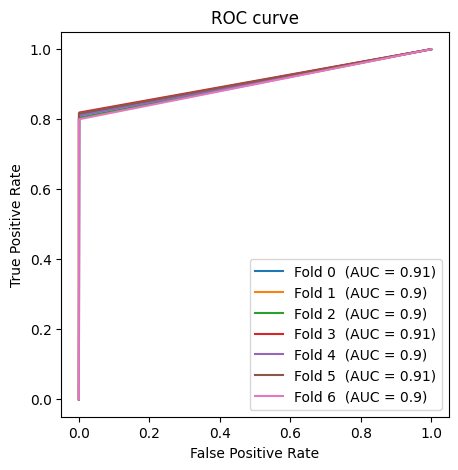

In [88]:
ss = ShuffleSplit(n_splits=7, test_size=0.3)
fig, ax = plt.subplots(figsize=(5, 5))

for split_number, (train_index, test_index) in enumerate(ss.split(x, y)):
    print("Split:", split_number)

    # print("Start: ", model.startprob_, "Transmission: ", model.transmat_, "Emission :", model.emissionprob_)

    X_train, X_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]

    print("Train:", train_index)
    print("Test", test_index)

    X_train = X_train.astype(int)

    # Fit the model and predict probabilities for the test set
    model_categorical.fit(X_train)
    logprob, state_ests = model_multi.decode(X_test)

    y_pred_proba = state_ests

    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc_score = roc_auc_score(y_test, y_pred_proba)

    print(confusion_matrix(y[test_index], y_pred_proba))

    # Plot the ROC curve for the current fold
    ax.plot(
        fpr, tpr, label="Fold {}  (AUC = {})".format(split_number, round(auc_score, 2))
    )

    print("Learned emission probs:")
    print(model_multi.emissionprob_)
    print("------------------------------------")
    print("Learned transition matrix:")
    print(model_multi.transmat_)


# Plot the ROC curve
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve")
plt.legend()
plt.show()





In [89]:
# %%!
dc_lst = []
for i in [1, 2, 3]:
    dc_lst.append({"fold": i, "prop_C1": 0.2, "prop_C2": 0.5})

x_df = pd.DataFrame(dc_lst)

In [90]:
x_df

,fold,prop_C1,prop_C2
0,1,0.2,0.5
1,2,0.2,0.5
2,3,0.2,0.5
